# The problem of data scaling in quantum machine learning

In many machine learning algorithms, it is necessary to scale the data to a standard format in order to get good performance. Quantum machine learning is certainly not immune from this, and suffers from this issue particularly strongly. To illustrate this, we will set up a simple 1D regression problem. 

First we define some data using a simple sinusoid function plus some noise:

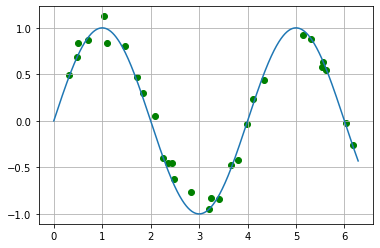

In [238]:
import numpy as np 
import matplotlib.pyplot as plt
np.random.seed(2022)


def generate_data_regression(inputs: np.ndarray, noise: float = 0, freq=2 * np.pi / 10):
    """Function used to generate noisy data."""
    data = np.sin(freq * inputs)
    # add some random noise to data
    noisy_data = data + np.random.normal(0,noise,len(data))
    return data, noisy_data

points = np.arange(0, 2*np.pi, 0.01)
X = np.random.choice(points,30,replace=False)

freq= np.pi/2
labels, Y = generate_data_regression(X, noise=0.1,freq=freq)

# Plot data
x_points = np.linspace(0, 2*np.pi, 1000)

plt.scatter(X, Y, color="green")

plt.plot(x_points, np.sin(freq * x_points))
plt.grid()
plt.show()

We will try to fit this data using a simple 1D quantum model. We will use JAX to speed things up.

In [239]:
import jax
import jax.numpy as jnp
import pennylane as qml

dev = qml.device("default.qubit", wires=1)
@jax.jit
@qml.qnode(dev,interface="jax")
def circuit(weights,input_data):
    qml.RX(weights[-1],wires=0)
    for layer in range(len(weights)):
        qml.RX(input_data,wires=0)
        qml.RY(weights[layer],wires=0)
    return qml.expval(qml.PauliZ(0))

vcircuit = jax.vmap(circuit,(None,0)) #the vectorised circuit

In [240]:
def square_loss(labels, predictions):
    """Square loss."""
    loss = jnp.sum((labels-predictions)**2)
    loss = loss/len(labels)
    return loss

def cost(params, input_data, labels):
    """Cost function."""
    predictions = vcircuit(params['w'], input_data)
    return square_loss(labels, predictions) 

To optimise the model we make use of optax, an optimisation package for JAX.

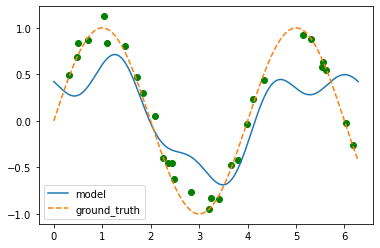

Iter:   991 | Cost: 0.1194743


In [241]:
import optax
from IPython.display import clear_output

layers=3
lr=0.1 #learning rate
params = {'w': np.random.rand(layers+1)} 
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

for it in range(1000):
    cst, grads = jax.value_and_grad(cost)(params, X, Y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)    
    model_plot = vcircuit(params['w'], x_points)
    
    if it%10==0:
        clear_output(wait=True)
        plt.plot(x_points,model_plot,label='model')
        plt.plot(x_points, np.sin(freq * x_points),linestyle='dashed',label='ground_truth')
        plt.scatter(X, Y, color="green")
        plt.legend()
        plt.show()
        print(f"Iter: {it + 1:5d} | Cost: {cst:0.7f}")


We can see that the quantum model struggles to find a frequency that matches the data. This is because quantum machine learning models can be written as a truncated fourier series

$$f_w(x)=\sum_{w\in\Omega}c_w(\omega)e^{i \omega\cdot x}.$$

The avaliable frequencies $\Omega$ depend on the eigenvalue structure of the data encoding gates and the number of times the data is encoded into the circuit. In our case we have 

$$\Omega = \{-L,-L+1,\cdots,L-1,L\}$$

where $L$ is the number of layers. Since our data was sampled from a sin wave with frequency $\pi/2$, the quantum model does not have access to this frequency as it can only access integer values. 

To try and remedy this situation we will introduce some new trainable parameters called ``scalings`` that *scale* the data. In principle, this gives the model access to all possible frequencies.

In [252]:
dev = qml.device("default.qubit", wires=1)
@jax.jit
@qml.qnode(dev,interface="jax")
def circuit(weights,scalings,input_data):
    "new model with data scaling"
    qml.RX(weights[-1],wires=0)
    for layer in range(len(weights)):
        qml.RX(input_data*scalings[layer],wires=0)
        qml.RY(weights[layer],wires=0)
    return qml.expval(qml.PauliZ(0))

vcircuit = jax.vmap(circuit,(None,None,0)) #the vectorised circuit

def cost(params, input_data, labels):
    """Cost function."""
    predictions = vcircuit(params['w'],params['s'], input_data)
    return square_loss(labels, predictions) 

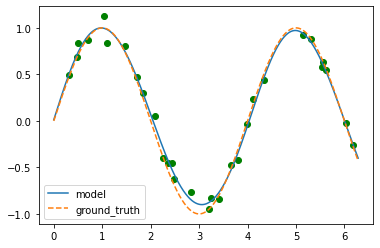

Iter:   991 | Cost: 0.0047725


In [247]:
def optimise_model(params,X,Y,lr=0.01,initial_scaling=1.0):
    params = {'w': np.random.rand(layers+1),'s': np.ones(layers)*initial_scaling} 
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)
    for it in range(1000):
        cst, grads = jax.value_and_grad(cost)(params, X, Y)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)    
        model_plot = vcircuit(params['w'],params['s'], x_points)

        if it%10==0:
            clear_output(wait=True)
            plt.plot(x_points,model_plot,label='model')
            plt.plot(x_points, np.sin(freq * x_points),linestyle='dashed',label='ground_truth')
            plt.scatter(X, Y, color="green")
            plt.legend()
            plt.show()
            print(f"Iter: {it + 1:5d} | Cost: {cst:0.7f}")

optimise_model(params,X,Y)

With this greater expressivity, the model is able to find a good fit to the data. However, with great expresivity comes great power. In a general learning problem, we will not know the frequency of the data, and the initial value of the scaling may be poorly matched with the frequency of the data. For example, let's run the same optimisation but with a larger initial scaling of the data. 

In [251]:
optimise_model(params,X,Y,initial_scaling=20,lr=0.1)

KeyboardInterrupt: 

The model now cannot find a good fit to the data, and shows signs of overfitting. In fact, this is somewhat to be expected, since it is known that such a model has [inifinite VC dimension](https://meticulousdatascience.com/journal/vc-dimension.html).

This small investigation points to two things:
- Introducing trainable parameters to scale the data seems to be a good idea for QML models
- One needs a method to set the initial data scale so that the frequency of the QML model matches that of the data

In the rest of this notebook we will look at methods to tackle the second point above. 

Note that one could also add regularisation to the scaling parameters to control the complexity of the model. This works quite well, although one still has the problem of how to decide how large the regularisation parameter should be, which is still related to the frequency scale of the data. 


# Scaling data via the discrete fourier transform

# A scalable heuristic for regression via random fourier features

# Applying the method to real world data